In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import os
import pandas as pd

In [2]:
"""Mounting Google Drive"""
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
import seaborn as sns
sns.set_context('paper', font_scale=2)

In [4]:
folder_path = "/content/drive/MyDrive/Features ASD_TD/"

# Initialize an empty list to store the combined data and labels
data_list = []
labels = []
# Iterate through the ASD and TD folders
for label, folder_name in enumerate(["ASD", "TD"]):
    folder_dir = os.path.join(folder_path, folder_name)

    # Iterate through files in each folder
    for file_name in os.listdir(folder_dir):
        if file_name.endswith(".xlsx"):
            file_path = os.path.join(folder_dir, file_name)
            # Check if the corresponding bands file exists
            bands_file_path = os.path.join(folder_dir, file_name.split('.')[0] + "_bands.xlsx")
            if os.path.exists(bands_file_path):
                # Read both excel files
                df_main = pd.read_excel(file_path)
                df_bands = pd.read_excel(bands_file_path)
                # Combine along columns
                combined_df = pd.concat([df_main, df_bands], axis=1)
                # Append the combined data and label to the list
                data_list.append(combined_df)
                labels.append(label)

In [16]:
np.shape(data_list)

(29, 100, 11)

In [5]:
from sklearn.preprocessing import StandardScaler

data_2d = np.asarray(data_list).reshape(-1, np.asarray(data_list).shape[-1])

scaler = StandardScaler()
scaled_data_2d = scaler.fit_transform(data_2d)
data = scaled_data_2d.reshape(np.asarray(data_list).shape)

In [6]:
""" Data Augmentation"""

def augment_data(data, labels, target_samples=1000, noise_factor=0.5):
    augmented_data = []
    augmented_labels = []

    while len(augmented_data) < target_samples:
        idx = np.random.randint(0, len(data))
        original_sample = data[idx]
        original_label = labels[idx]

        noisy_sample = original_sample + noise_factor * np.random.normal(size=original_sample.shape)

        augmented_data.append(noisy_sample)
        augmented_labels.append(original_label)

    augmented_data = np.array(augmented_data)
    augmented_labels = np.array(augmented_labels)

    return augmented_data, augmented_labels

augmented_data, augmented_labels = augment_data(data, labels, target_samples=1000, noise_factor=0.0005)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(augmented_data, augmented_labels, test_size=0.2, random_state=42)

In [8]:
timesteps = 100
n_features = 11
encoding_dim = 10  # Adjust encoding dimensions as needed

inputs = Input(shape=(timesteps, n_features))

# Encoder
encoded = LSTM(128, return_sequences=True)(inputs)
encoded = Dropout(0.2)(encoded)
encoded = LSTM(64, return_sequences=True)(encoded)
encoded = Dropout(0.2)(encoded)
encoded = LSTM(encoding_dim)(encoded)

# Decoder
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(encoding_dim, return_sequences=True)(decoded)
decoded = Dropout(0.2)(decoded)
decoded = LSTM(64, return_sequences=True)(decoded)
decoded = Dropout(0.2)(decoded)
decoded = LSTM(128, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(n_features))(decoded)

autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history  = autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=16,
                validation_split=0.1,
                callbacks=[reduce_lr])

# Encode the training and test data
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

Epoch 1/50
45/45 [==============================] - 15s 77ms/step - loss: 0.8798 - val_loss: 0.7601 - lr: 0.0010
Epoch 2/50
45/45 [==============================] - 1s 26ms/step - loss: 0.7180 - val_loss: 0.6865 - lr: 0.0010
Epoch 3/50
45/45 [==============================] - 1s 25ms/step - loss: 0.6752 - val_loss: 0.7292 - lr: 0.0010
Epoch 4/50
45/45 [==============================] - 1s 24ms/step - loss: 0.6586 - val_loss: 0.6180 - lr: 0.0010
Epoch 5/50
45/45 [==============================] - 1s 29ms/step - loss: 0.6465 - val_loss: 0.6311 - lr: 0.0010
Epoch 6/50
45/45 [==============================] - 2s 35ms/step - loss: 0.5938 - val_loss: 0.5865 - lr: 0.0010
Epoch 7/50
45/45 [==============================] - 2s 35ms/step - loss: 0.5640 - val_loss: 0.5488 - lr: 0.0010
Epoch 8/50
45/45 [==============================] - 1s 25ms/step - loss: 0.5304 - val_loss: 0.5011 - lr: 0.0010
Epoch 9/50
45/45 [==============================] - 1s 24ms/step - loss: 0.5315 - val_loss: 0.5024 - lr

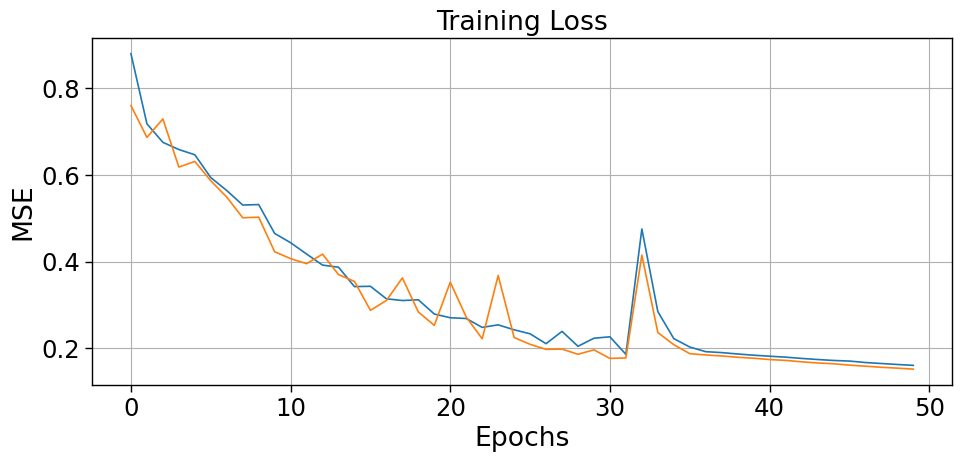

In [9]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid(True)

plt.tight_layout()

# Save as EPS
plt.savefig('loss.eps', format='eps')

# Save as PDF
plt.savefig('loss.pdf', format='pdf')

plt.show()

In [10]:
# Train the XGBoost regressor
xgb_regressor = XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.0001)
xgb_regressor.fit(X_train_encoded, y_train)

# Predict using XGBoost regressor
xgb_train_predictions = xgb_regressor.predict(X_train_encoded)
xgb_test_predictions = xgb_regressor.predict(X_test_encoded)

In [11]:
# Train the Linear Regression model on the XGBoost outputs
linear_regressor = LinearRegression()
linear_regressor.fit(xgb_train_predictions.reshape(-1, 1), y_train)

# Predict using Linear Regression model
final_train_predictions = linear_regressor.predict(xgb_train_predictions.reshape(-1, 1))
final_test_predictions = linear_regressor.predict(xgb_test_predictions.reshape(-1, 1))

threshold = 0.5
final_test_predictions_class = (final_test_predictions > threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, final_test_predictions_class)
print(f'Final Model Accuracy: {accuracy:.2f}')

Final Model Accuracy: 0.98


In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score



conf_matrix = confusion_matrix(y_test, final_test_predictions_class)
accuracy = accuracy_score(y_test, final_test_predictions_class)
precision = precision_score(y_test, final_test_predictions_class)
recall = recall_score(y_test, final_test_predictions_class)
f1 = f1_score(y_test, final_test_predictions_class)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Confusion Matrix:
 [[99  4]
 [ 0 97]]
Accuracy: 0.98
Precision: 0.9603960396039604
Recall: 1.0
F1-score: 0.9797979797979798


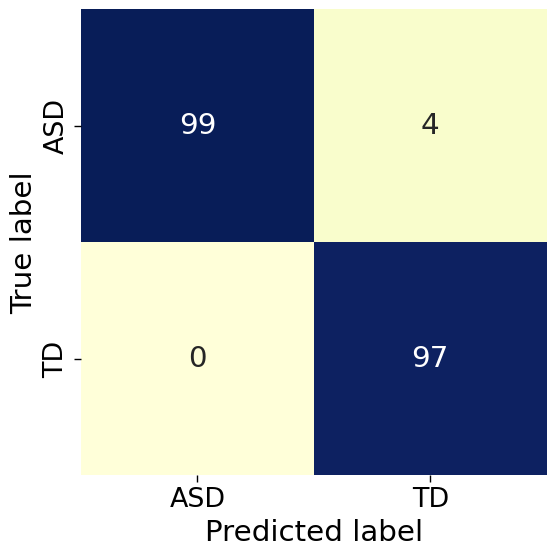

In [13]:
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sns.set_context('paper', font_scale=2.2)
sns.heatmap(conf_matrix, annot=True, cmap='YlGnBu', fmt='g',
            xticklabels=['ASD', 'TD'],
            yticklabels=['ASD', 'TD'],
            cbar=False)  # Remove the color bar
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.savefig('conf_EEFM.eps', format='eps')
plt.savefig('conf_EEFM.pdf', format='pdf')
plt.show()